In [1]:
import pandas as pd

df  = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9623,2024-05-20,420.209991,426.769989,419.989990,425.339996,425.339996,16272100
9624,2024-05-21,426.829987,432.970001,424.850006,429.040009,429.040009,21453300
9625,2024-05-22,430.089996,432.410004,427.130005,430.519989,430.519989,18073700
9626,2024-05-23,432.970001,433.600006,425.420013,427.000000,427.000000,17211700


In [2]:
df = df[['Date', 'Close']]

type(df['Date'][0])

str

In [3]:
# The date type is a string,it needs to be converted to datetime type
import datetime
def str_to_datetime(date_str):
    # Utility function to convert a date string to a datetime object
    return datetime.datetime.strptime(date_str, '%Y-%m-%d')

datetime_object = str_to_datetime('2007-09-17')
datetime_object

datetime.datetime(2007, 9, 17, 0, 0)

In [4]:
#Apply the above function to the entire dataset
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-4-85c11aec0b49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9623   2024-05-20
9624   2024-05-21
9625   2024-05-22
9626   2024-05-23
9627   2024-05-24
Name: Date, Length: 9628, dtype: datetime64[ns]

In [5]:
#Make the date column the index column
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-05-20,425.339996
2024-05-21,429.040009
2024-05-22,430.519989


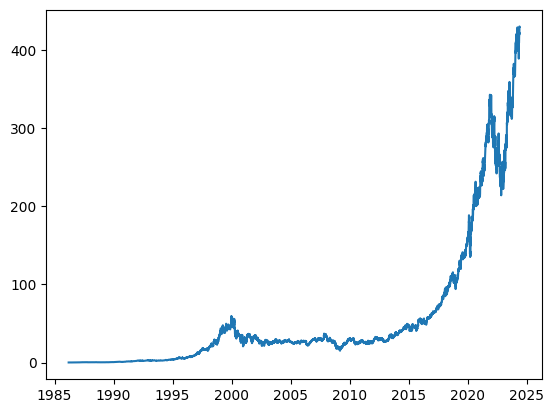

In [6]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [7]:

"""
# Now because we're using the LSTM model, we need to convert this into a supervised learning problem
The function takes a DataFrame with dates and target values and creates
input-output pairs where each input consists of the target values
from the previous n days, and the output is the target value of the next day.
For example, if n = 3, input = (target-3, target-2, target-1) And output = target
target -3, -2, and -1 are the stock prices of 3 days before, 2 days before and 1 days
before the date at which price = target
"""
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert the date strings to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date  # Initialize the target date to the first date
    dates = []  # List to store target dates
    X, Y = [], []  # Lists to store input and output sequences

    last_time = False  # Flag to indicate the last iteration
    while True:
        # Get the subset of the dataframe up to the current target date
        df_subset = dataframe.loc[:target_date].tail(n+1)

        # Check if the subset has the correct size
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        # Convert the 'Close' column values to a numpy array
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]  # Split into input (x) and output (y)

        dates.append(target_date)  # Add the target date to the list
        X.append(x)  # Add the input sequence to the list
        Y.append(y)  # Add the output value to the list

        # Get the next week's data to find the next target date
        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        # Check if this is the last iteration
        if last_time:
            break

        target_date = next_date  # Update the target date

        if target_date == last_date:
            last_time = True  # Set the flag to indicate the last iteration

    # Create a DataFrame to store the results
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates  # Add target dates

    # Convert the list of input sequences to a numpy array
    X = np.array(X)
    # Add each element of the input sequence to the DataFrame
    for i in range(0, n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y  # Add the output values

    return ret_df  # Return the resulting DataFrame

# Example usage

windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [8]:
"""
transform the windowed DataFrame into three arrays: dates, input features (X),
and output labels (Y), making it ready for use in an LSTM model.

The function windowed_df_to_date_X_y converts a windowed DataFrame into three
arrays: dates, input features (X), and output labels (Y), making it suitable for
LSTM models. It first converts the DataFrame to a numpy array, extracts the
dates from the first column, the input features from the middle columns, and
the output labels from the last column. The input features are reshaped to a
3D array with dimensions (samples, timesteps, features), and all arrays are
converted to type float32. This transformation prepares the data for LSTM input,
ensuring correct shape and data type compatibility.

Input Features (X):

These are the historical values of the 'Close' price of the stock for a certain
 number of previous days, specified by the parameter n in the df_to_windowed_df
  function. Each row of the input features array X represents a sequence of
  historical 'Close' prices leading up to a specific date.

Output Labels (Y):

These are the 'Close' prices of the stock for the next day after the
corresponding sequence of historical prices in the input features array X.
Each element of the output labels array Y corresponds to the 'Close' price of
the stock for the day immediately following the historical sequence represented
by the corresponding row in X.
"""

def windowed_df_to_date_X_y(windowed_dataframe):
    # Convert the windowed dataframe to a numpy array
    df_as_np = windowed_dataframe.to_numpy()

    # Extract the first column (dates) from the numpy array
    dates = df_as_np[:, 0]

    # Extract the middle columns (input features) from the numpy array, but this is a wrong shape for the LSTM
    middle_matrix = df_as_np[:, 1:-1]
    # Reshape the input features to be 3-dimensional (samples, timesteps, features)
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    # Extract the last column (output labels) from the numpy array
    Y = df_as_np[:, -1]

    # Return the dates, input features, and output labels, ensuring inputs and outputs are of type float32
    return dates, X.astype(np.float32), Y.astype(np.float32)

# Transform the windowed DataFrame into dates, input features, and output labels
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Output the shapes of the resulting arrays
dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

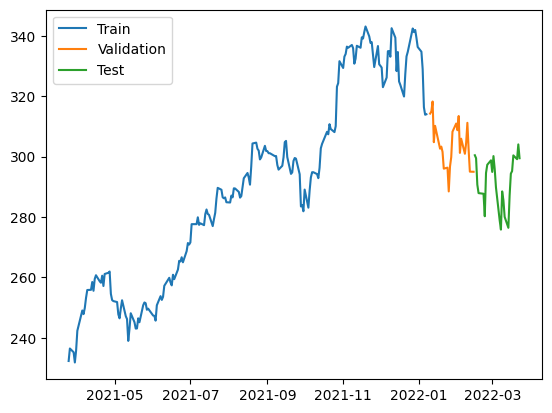

In [9]:
# splits the dataset into training, validation, and test sets

# Calculate the indices for splitting the dataset
q_80 = int(len(dates) * .8)  # 80% of the data for training
q_90 = int(len(dates) * .9)  # 10% of the data for validation and test each

# Split the dates, input features, and output labels into training, validation, and test sets
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]  # Training set
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]  # Validation set
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]  # Test set

# Plot the target variable across different sets
plt.plot(dates_train, y_train)  # Plot training set
plt.plot(dates_val, y_val)  # Plot validation set
plt.plot(dates_test, y_test)  # Plot test set

# Add legend to the plot
plt.legend(['Train', 'Validation', 'Test'])


In [35]:
# Check for NaN values in X_train, y_train, X_val, and y_val
print("NaN values in X_train:", np.isnan(X_train).any())
print("NaN values in y_train:", np.isnan(y_train).any())
print("NaN values in X_val:", np.isnan(X_val).any())
print("NaN values in y_val:", np.isnan(y_val).any())

NaN values in X_train: False
NaN values in y_train: False
NaN values in X_val: False
NaN values in y_val: False


In [35]:
# Impute missing values in X_train and y_train with mean
X_train[np.isnan(X_train)] = np.nanmean(X_train)
y_train[np.isnan(y_train)] = np.nanmean(y_train)

# Check if NaN values have been successfully imputed
print("NaN values in X_train after imputation:", np.isnan(X_train).any())
print("NaN values in y_train after imputation:", np.isnan(y_train).any())


NaN values in X_train after imputation: False
NaN values in y_train after imputation: False


In [36]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on training data and transform training, validation, and test data
X_train_normalized = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_val_normalized = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test_normalized = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

"""from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

This is causing overfitting. Maybe adding dropout layers randomly to deactive a fraction of neurons during
training would help the model to generalize better.

"""
"""from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define the model with dropout and batch normalization
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, kernel_regularizer=l2(0.01)), # LSTM(64),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),#Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])"""



Epoch 1/100
7/7 [==============================] - 5s 107ms/step - loss: 84661.6406 - mean_absolute_error: 289.2273 - val_loss: 92260.2578 - val_mean_absolute_error: 303.6565
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 84297.1953 - mean_absolute_error: 288.5944 - val_loss: 91982.9375 - val_mean_absolute_error: 303.1996
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 84084.1719 - mean_absolute_error: 288.2240 - val_loss: 91759.2578 - val_mean_absolute_error: 302.8304
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 83852.1797 - mean_absolute_error: 287.8219 - val_loss: 91483.2812 - val_mean_absolute_error: 302.3744
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 83565.3516 - mean_absolute_error: 287.3250 - val_loss: 91139.2891 - val_mean_absolute_error: 301.8051
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 83207.2500 - mean_absolute_error: 286.6981 - val_loss: 906

"from tensorflow.keras.models import Sequential\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization\nfrom tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau\nfrom tensorflow.keras.regularizers import l2\n\n# Define the model with dropout and batch normalization\nmodel = Sequential([\n    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),\n    BatchNormalization(),\n    Dropout(0.3),\n    LSTM(64, kernel_regularizer=l2(0.01)), # LSTM(64),\n    BatchNormalization(),\n    Dropout(0.3),\n    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),#Dense(32, activation='relu'),\n    Dropout(0.3),\n    Dense(1)\n])\n\n# Compile the model\nmodel.compile(loss='mse', \n              optimizer=Adam(learning_rate=0.001),\n              metrics=['mean_absolute_error'])\n\n# Early stopping callback\nearly_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_wei

7/7 [==============================] - 1s 4ms/step


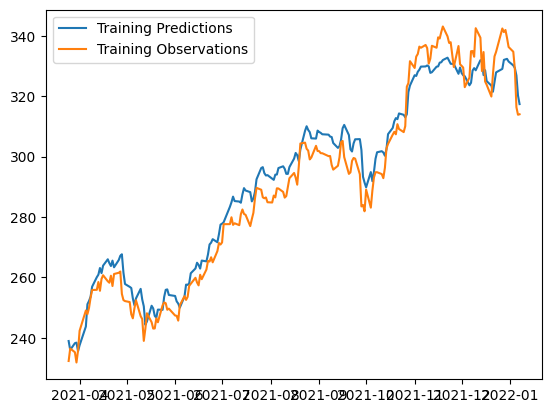

In [11]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 22ms/step


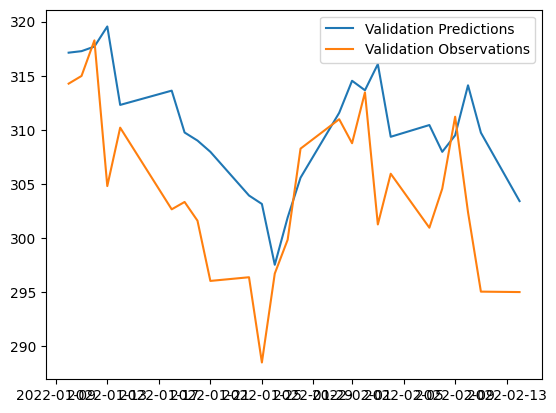

In [12]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 21ms/step


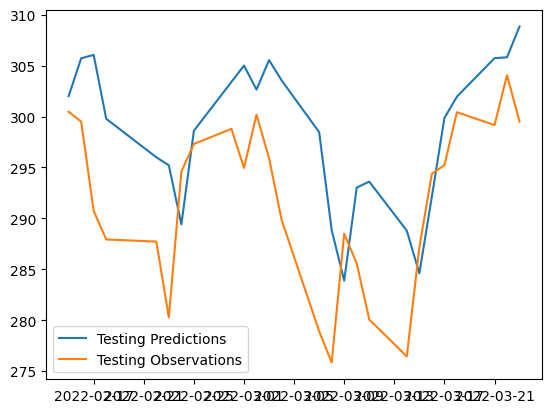

In [13]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

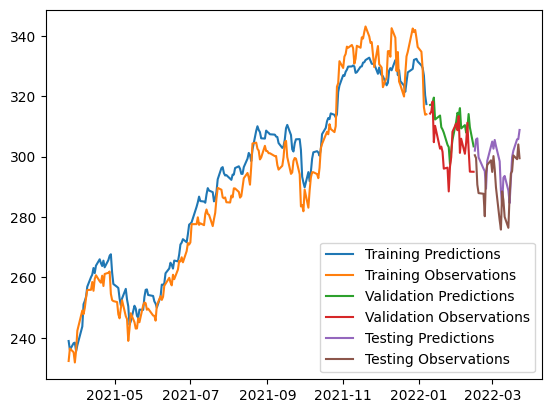

In [14]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [15]:
"""
recursive prediction approach for generating future predictions using the trained model
"""
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 32ms/step


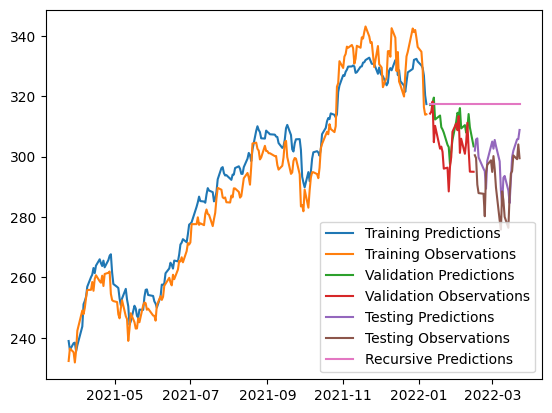

In [16]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

1/1 [==============================] - 0s 24ms/step
Training Loss: 41.3791, Validation Loss: 66.9168
Test RMSE: 9.3605
Training MAE: 5.6086, Validation MAE: 6.4538, Test MAE: 7.8533
Training MAPE: 1.94%, Validation MAPE: 2.15%, Test MAPE: 2.73%


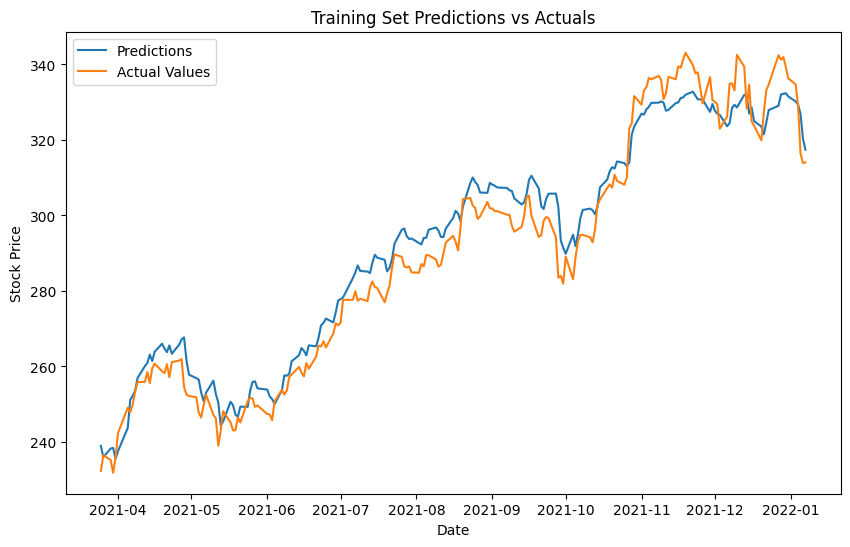

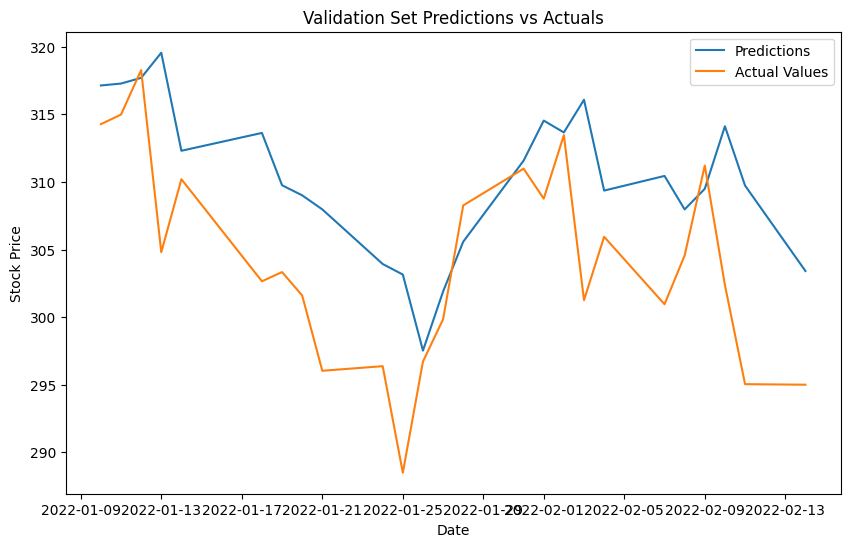

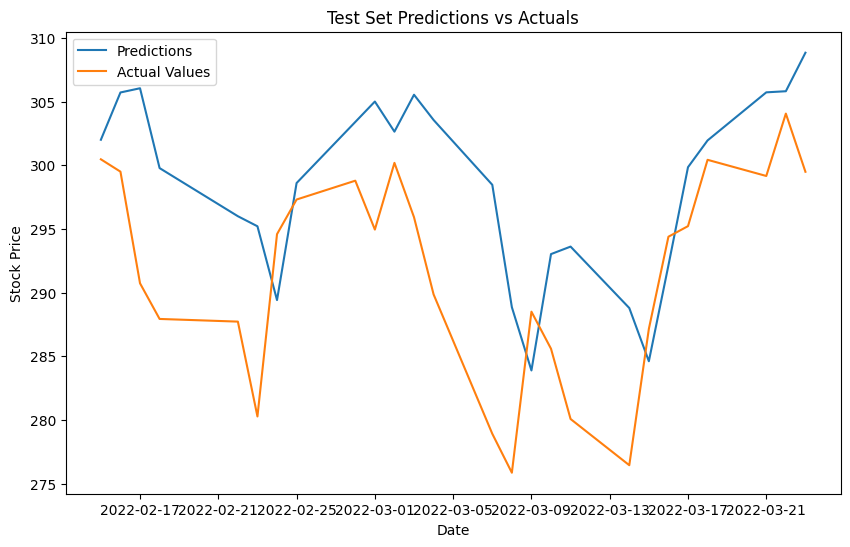

In [17]:
#Evaluation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Assuming the following variables are defined:
# model - your trained LSTM model
# X_train, y_train - training data and labels
# X_val, y_val - validation data and labels
# X_test, y_test - test data and labels

# Evaluate the model on the training, validation, and test sets
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Make predictions
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate MAPE
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)

# Print evaluation figures
print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}, Validation MAE: {val_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Training MAPE: {train_mape:.2%}, Validation MAPE: {val_mape:.2%}, Test MAPE: {test_mape:.2%}")

# Plot the predictions vs actual values for train, validation, and test sets
def plot_predictions(dates, predictions, actuals, title):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, predictions, label='Predictions')
    plt.plot(dates, actuals, label='Actual Values')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Assuming dates_train, dates_val, and dates_test are the date ranges for each dataset
plot_predictions(dates_train, train_predictions, y_train, 'Training Set Predictions vs Actuals')
plot_predictions(dates_val, val_predictions, y_val, 'Validation Set Predictions vs Actuals')
plot_predictions(dates_test, test_predictions, y_test, 'Test Set Predictions vs Actuals')
